# import library

In [87]:
import os
import mmcv
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from glob import glob
from mmcv.ops import nms
from ipywidgets import interact
from mmcv import Config, DictAction
from mmdet.datasets import build_dataset
from matplotlib.ticker import MultipleLocator
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps


# GT, Predict wrong, right 시각화

In [3]:
config_path = 'config 파일 경로'
# '/opt/ml/detection/baseline/mmdetection/configs/my_model/faster_rcnn_r50_fpn_1x_coco_custom.py'

prediction_path = '피클 파일 경로'
# '/opt/ml/detection/baseline/mmdetection/work_dirs/test/result.pkl'

# default_setting
color_theme='plasma'
score_thr = 0.3
tp_iou_thr = 0.5
nms_iou_thr = None
palette = sns.color_palette('bright')
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

In [4]:
cfg = Config.fromfile(config_path)

results = mmcv.load(prediction_path)
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
dataset = build_dataset(cfg.data.test)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [75]:
def pltSetting(ax, fname):
    title = ['GT', 'Pos', 'Neg']
    img = io.imread(fname)
    for i in range(3):
        ax[i].imshow(img)
        
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        ax[i].set_title(title[i])


In [85]:
@interact(img_idx=(0, len(results)-1), score_thr=(0., 1., 0.05), tp_iou_thr=(0., 1., 0.05), cls_num=(0, 10))
def calculate_confusion_matrix(img_idx=0, score_thr=0,tp_iou_thr=0.5, cls_num=10):
    """Calculate the confusion matrix.

    Args:
        dataset (Dataset): Test or val dataset.
        results (list[ndarray]): A list of detection results in each image.
        score_thr (float|optional): Score threshold to filter bboxes.
            Default: 0.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
        tp_iou_thr (float|optional): IoU threshold to be considered as matched.
            Default: 0.5.
    """

    nms_iou_thr=None
    num_classes = len(dataset.CLASSES)
    confusion_matrix = np.zeros(shape=[num_classes + 1, num_classes + 1])
    assert len(dataset) == len(results)

    per_img_res = results[img_idx]
    fname = dataset[img_idx]['img_metas'][0].data['filename'] 
    # 차례대로 fname을 가져온다.
    
    if isinstance(per_img_res, tuple):
        res_bboxes, _ = per_img_res
    else:
        res_bboxes = per_img_res
    ann = dataset.get_ann_info(img_idx)
    gt_bboxes = ann['bboxes']
    gt_labels = ann['labels']
    
    # analyze_per_img_dets(fname, confusion_matrix, gt_bboxes, gt_labels, res_bboxes, cls_num,
    #                         score_thr, tp_iou_thr, nms_iou_thr) # cls_num, fname

    true_positives = np.zeros_like(gt_labels)
    
    fig, ax = plt.subplots(1, 3, dpi=250)
    pltSetting(ax, fname)

    for gt_label_idx, gt_bbox in enumerate(gt_bboxes):
        gt_label = gt_labels[gt_label_idx]
        x,y,x1,y1 = gt_bbox[:4]
        ax[0].add_patch(
                patches.Rectangle(
                    (x,y), x1-x, y1-y,
                    edgecolor=palette[gt_label],
                    linewidth=1,
                    fill=False,
                ),
            )
        text_y = y-30 if y>30 else y+30
        plt_text = ax[0].text(x+18,text_y, f'{classes[gt_label]}', color='white', fontsize='4', weight='semibold')
        plt_text.set_bbox(dict(
            facecolor=palette[gt_label],  # background color
            alpha=0.6,  # background alpha
            edgecolor='none',  # border color
            pad=2
        ))

    for det_label, det_bboxes in enumerate(res_bboxes):
        if(cls_num!=10 and cls_num!=det_label):
             continue 

        ious = bbox_overlaps(det_bboxes[:, :4], gt_bboxes)

        # 모든 pred와 gt iou 계산
        for i, det_bbox in enumerate(det_bboxes):
            score = det_bbox[4]
            x,y,x1,y1 = det_bbox[:4]
            det_match = 0
            if score >= score_thr:
                # score가 threshold보다 낮은 거 기본적으로 제거
                for j, gt_label in enumerate(gt_labels):
                    if ious[i, j] >= tp_iou_thr:
                        # 만약 i번째 detected box와 j번째 gt box의 겹치는 정도가 tp_iou_thr보다 크다면 match시켜줌
                        if gt_label == det_label:
                            # 만약 gt와 detection의 라벨이 같다면
                            det_match += 1
                if det_match == 0:  # BG FP
                    # gt와 detection이 match된 게 1개도 없다면 Background 1 증가,
                    ax_idx = 2
                else:
                    ax_idx = 1

                ax[ax_idx].add_patch(
                        patches.Rectangle(
                            (x,y), x1-x, y1-y,
                            edgecolor=palette[det_label],
                            linewidth=1,
                            fill=False,
                        ),
                    )
                text_y = y-30 if y>30 else y+30
                plt_text = ax[ax_idx].text(x+18,text_y, f'{classes[det_label]}', color='white', fontsize='4', weight='semibold')
                plt_text.set_bbox(dict(
                    facecolor=palette[det_label],  # background color
                    alpha=0.6,  # background alpha
                    edgecolor='none',  # border color
                    pad=2
                ))



interactive(children=(IntSlider(value=0, description='img_idx', max=4882), FloatSlider(value=0.0, description=…

In [ ]:
("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# 틀린 ground truth 통계치 구하기

In [126]:
result_df_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/test/wrong_bbox.csv'
result_df = pd.read_csv(result_df_path)

result_df['label'] = result_df['label'].apply(lambda x : classes[x])
result_df.head(10)

,fname,label,area,aspect_ratio,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,/opt/ml/detection/dataset/train/0001.jpg,Metal,10402.5610,3.135417,0.0,407.4,57.6,588.0
1,/opt/ml/detection/dataset/train/0001.jpg,Glass,69096.1640,0.918338,722.3,313.4,996.6,565.3
2,/opt/ml/detection/dataset/train/0001.jpg,Plastic,24164.5880,0.442448,353.2,671.0,586.9,774.4
3,/opt/ml/detection/dataset/train/0001.jpg,General trash,38908.7230,0.830869,425.3,681.9,641.7,861.7
4,/opt/ml/detection/dataset/train/0001.jpg,Plastic bag,7391.5170,0.381465,92.4,601.7,231.6,654.8
5,/opt/ml/detection/dataset/train/0001.jpg,General trash,6857.7600,1.293956,622.4,686.5,695.2,780.7
6,/opt/ml/detection/dataset/train/0003.jpg,Styrofoam,80710.5700,2.273885,773.3,3.0,961.7,431.4
7,/opt/ml/detection/dataset/train/0004.jpg,Paper,32987.7660,1.223508,859.4,411.7,1023.6,612.6
8,/opt/ml/detection/dataset/train/0004.jpg,Paper,32746.9960,1.937692,362.0,349.7,492.0,601.6
9,/opt/ml/detection/dataset/train/0004.jpg,General trash,4523.6416,0.441700,868.2,521.7,969.4,566.4


# class 별로 못 맞춘 instance min, max, mean 넓이 구하기

In [136]:
min_area_per_class = result_df.groupby(['label'])['area'].min()
max_area_per_class = result_df.groupby(['label'])['area'].max()
mean_aera_per_class = result_df.groupby(['label'])['area'].mean()
area_df = pd.DataFrame(columns=['min_area', 'max_area', 'mean_area'])
area_df['min_area']=min_area_per_class
area_df['max_area']=max_area_per_class
area_df['mean_area']=mean_aera_per_class
print(area_df)

                  min_area    max_area      mean_area
label                                                
Battery        1639.078600   285908.22   50409.963802
Clothing        867.921260  1047961.70  129101.975753
General trash   318.160580  1048064.06   28855.559926
Glass           666.049560   699923.94   62807.971071
Metal           275.119840   656199.56   48018.179786
Paper             3.119923  1047961.70   24197.042994
Paper pack       66.249850   900676.94   26043.741775
Plastic         105.080110  1036086.75   26810.894995
Plastic bag     301.708980  1048064.06   24410.115151
Styrofoam       682.950560   992374.80   43567.295063


# class 별로 못 맞춘 instance 영역 분포

<AxesSubplot:xlabel='area', ylabel='label'>

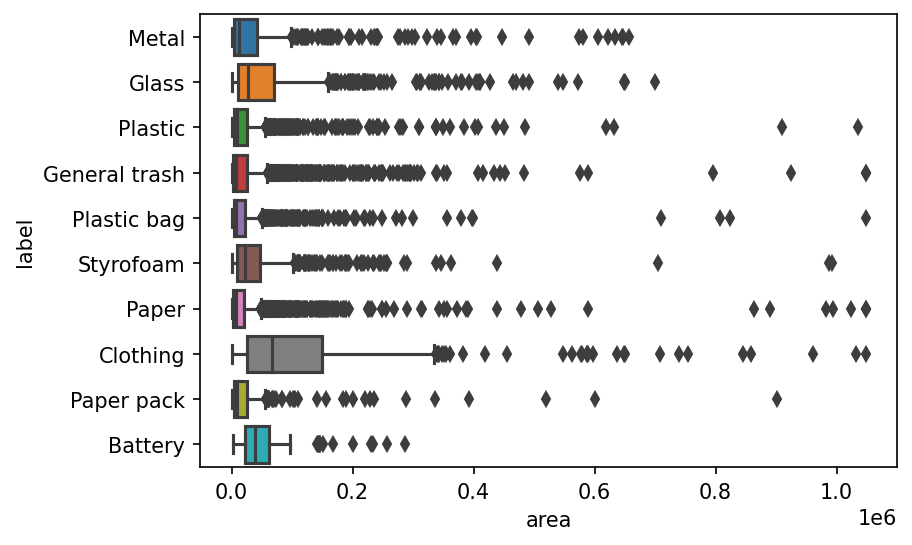

In [131]:
fig, ax = plt.subplots(1, 1, dpi = 150)
sns.boxplot(data=result_df, x='area', y='label', dodge=True, ax=ax)